## Introduction
In this blog post, I implement and test the perceptron algorithm using randomly generated data. The algorithm attempts to categorize data points but is only able reach a loss of zero if the data is linearly separable. I implement the minibatch perceptron algorithm as well, which computes weight updates using multiple observations at a time. For linearly separable data, I find it's possible to consistently achieve a loss of 0. For data that is not linearly separable, I don't achieve a loss of 0 with the minibatch perceptron algorithm (where number of observations = number of points used to update at once) but instead see a leveling out at a loss of around 0.28.

In [79]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Part A: Implement Perceptron

The below code, from our warmup, defines a function that generates a matrix and an array of random data.

In [80]:
import torch
from matplotlib import pyplot as plt

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,2))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

The below code is a quick check to ensure the Perceptron code was written correctly. The output of tensor(True) shows Perceptron is probably fine.

In [81]:
p = Perceptron()
s = p.score(X)
l = p.loss(X, y)
print(l)
print(l == 0.5)

tensor(0.5000)
tensor(True)


The below code is our core training loop as a function. As long as the loss exceeds our loss threshold (which by default is 0), we perform the optimizer's step function to update the weights and then try again. We only iterate up to our max iterations value, which is 1000 times by default.

If our final loss vector (loss_vec) value is 0, our program successfully found a weight vector that linearly separates our data. 

In [82]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []

def train(X, y, max_iterations = 1000, loss_threshold = 0.0):
    loss = 1.0

    # for keeping track of loss values and number of iterations
    j = 0
    n = X.size()[0]

    while loss > loss_threshold and j < max_iterations: # dangerous -- only terminates if data is linearly separable
        j += 1
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random data point
        i = torch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # perform a perceptron update using the random data point
        opt.step(x_i, y_i)
    return loss_vec

loss_vec = train(X,y)
print("Last Vector: " + str(loss_vec[len(loss_vec)-1]))
print(p.w)

Last Vector: tensor(0.)
tensor([ 2.5406,  0.9279, -1.8141])


The above output shows the final vector in loss_vec is a 0, showing we managed to find a set of weights that minimize the loss. The weights are shown above below the last vector in loss_vec.

# Part B: Experiments

We first create new data that is linearly separable.

In [83]:
import torch

torch.manual_seed(1234)

X, y = perceptron_data(n_points = 300, noise = 0.2)

### Part B, Subsection 1: Visualizing Results

In this subsection, we apply our algorithm to linearly separable data and visualize the results. 

The below code, from our lecture notes, defines two functions for visualization. plot_perceptron_data creates a graph for our observations, while draw_line draws the line representing our weight vector.

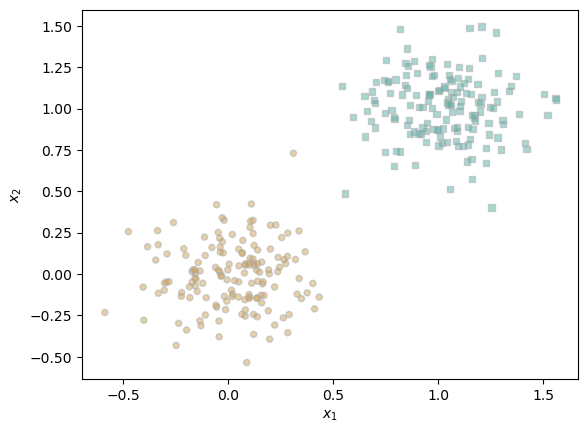

In [84]:
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

The above plot shows that we have data that is linearly separable--i.e., we can draw a line that can cleanly separate the green and yellow data points into two groups.

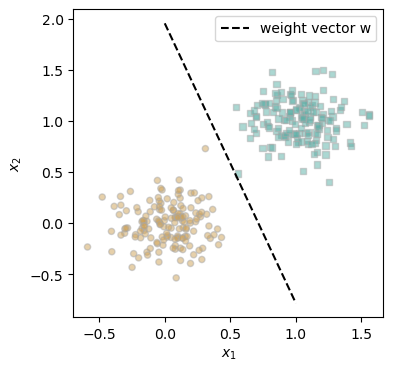

In [85]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

draw_line(p.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")

l = ax.legend(ncol = 2)

The above is a visualization and our weight vector w. We see that the data is correctly categorized into green and yellow groups.

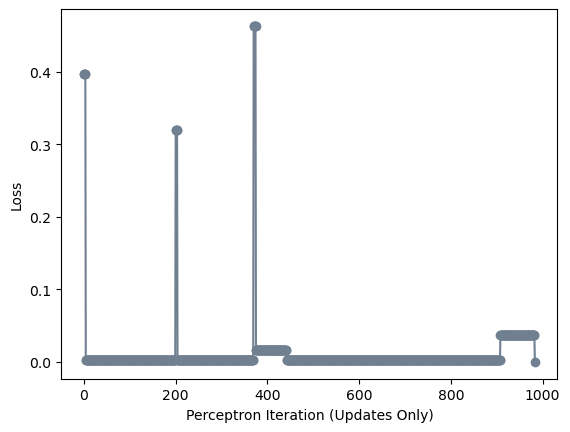

In [86]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

The above plot shows how many times it took our perceptron algorithm to achieve a loss of 0. We see that it almost reached our limit on the number of iterations (1000) to achieve this. We also see that the program quickly reached a <0.1 loss but spent many more iterations to reach 0.

### Part B, Subsection 2: Data that is Not Linearly Separable

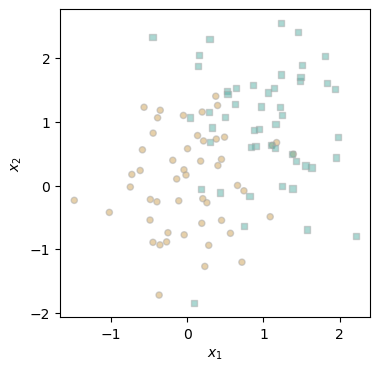

In [87]:
X, y = perceptron_data(100, 0.7)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

This data is not linearly separable, as can be seen by how some yellow points are surrounded by clusters of green points and how some green points are surrounded by yellow points. It's impossible for our algorithm to achieve a loss of 0 on this data.

Last Vector: tensor(0.2500)


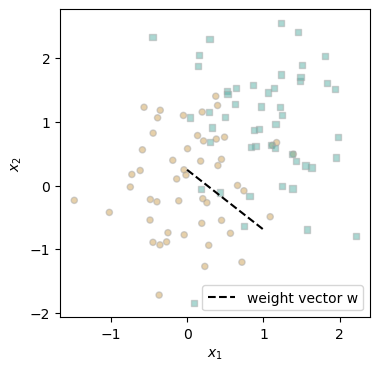

In [88]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []

loss_vec = train(X,y)
print("Last Vector: " + str(loss_vec[len(loss_vec)-1]))
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")
l = ax.legend(ncol = 2)

Above the graph is the loss of the last vector in loss_vec: 0.25. We can see this non-zero loss as well in the graph, which does a poor job of separating yellow and green dots.

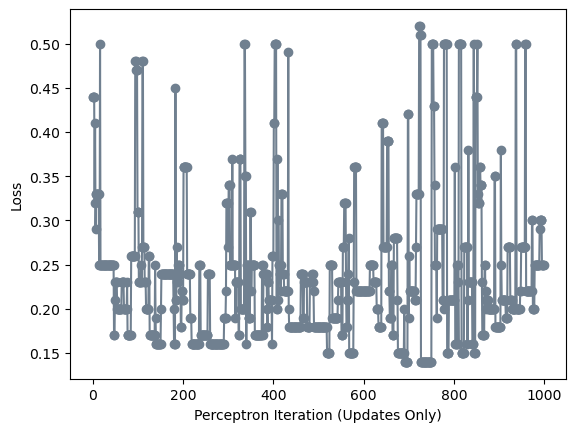

In [89]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

Although our final loss is relatively low, the above chart shows that this normal perceptron algorithm is unable to converge to some consistent loss value even with 1000 iterations when provided data that is not linearly separable.

### Part B, Subsection 3: Beyond 2-D

We define a new perceptron data generator called n_dimensional_perceptron_data, which just takes an additional argument f, which is the number of features our data will have. Besides the inclusion of f, this function is identical to perceptron_data.

We run the function with five features and print the first few rows of our X matrix to show that there are five feature columns in the matrix as desired.

In [90]:
def n_dimensional_perceptron_data(n_points = 300, noise = 0.2, f = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,f))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

a, b = n_dimensional_perceptron_data(100, 0.4, 5)

print("Our X matrix is: " + str(a[0:3]))

Our X matrix is: tensor([[-0.5557, -0.0346, -0.1967, -0.1971, -1.0845,  1.0000],
        [-0.1722, -0.3934, -0.1993,  0.4087,  0.7385,  1.0000],
        [-0.4329, -0.4910, -0.1504, -0.0563,  0.0661,  1.0000]])


The above output shows our X matrix has the desired number of features (5 features + 1 extra column for 1s).

Last Loss: tensor(0.)
Weight Vector: tensor([ 0.6102,  1.5002,  0.8634,  1.6297,  1.1812, -3.4453])


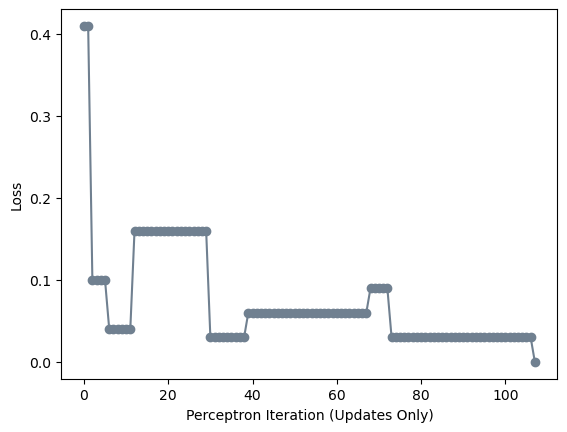

In [91]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []

train(a,b,5000)

print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))
print("Weight Vector: " + str(p.w))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")


Above the graph is a print statement showing the last item in our loss vector is 0.0, indicating that the data is linearly separable. I intentionally set the noise level so it was possible to linearly separate the data in 2-D, but I was still unsure whether it was possible to do so in higher dimensions.

### Part C: Minibatch Perceptron

In this section, I define a new train function, train_minibatch, which implements the minibatch perceptron algorithm. Instead of updating weights based on 1 point at a time, we make updates based on k observations at once. We also include lr, representing alpha or the learning rate, in the function.

In [92]:
def train_minibatch(X, y, max_iterations = 1000, loss_threshold = 0.0, k = 1, lr = 1.0):
    loss = 1.0

    # for keeping track of loss values and number of iterations
    j = 0

    while loss > loss_threshold and j < max_iterations: # dangerous -- only terminates if data is linearly separable
        j += 1
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random data point
        ix = torch.randperm(X.size(0))[:k]
        
        # perform a perceptron update using the random data point
        opt.step(X=X, y=y, lr=lr, ix=ix)
    return loss_vec

#### Experiment 1: k = 1

In this experiment, I check whether minibatch perceptron with k=1 is similar to our regular perceptron.

Below are two code chunks and two graphs. The first code chunk runs train_minibatch() on our dataset. It's followed by a graph representing loss values over time. The second code chunk runs the normal train() on our dataset. This is also followed by a graph representing loss values over time. The two graphs show that there is little difference between the algorithms.

Last Loss: tensor(0.)
Weight Vector: tensor([ 1.7420,  1.1295, -1.5927])


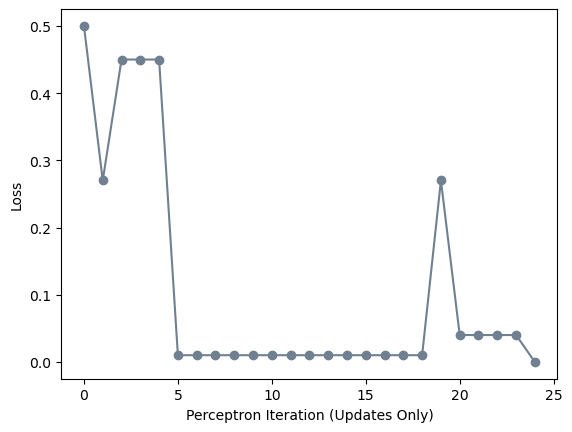

In [93]:
torch.manual_seed(1234)

X, y = perceptron_data(n_points = 100, noise = 0.2)

p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []
train_minibatch(X,y, k = 1)
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))
print("Weight Vector: " + str(p.w))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

Last Loss: tensor(0.)
Weight Vector: tensor([ 1.8037,  0.9660, -1.4911])


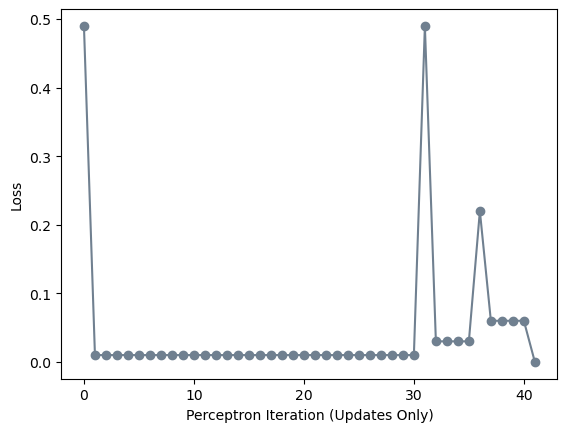

In [94]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []
train(X,y)
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))
print("Weight Vector: " + str(p.w))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

#### Experiment 2: k = 10

In this experiment, we see whether minibatch can still find a separating line in 2D when we increase the number of observations used in an update to 10. The effect is easy to see: it takes only one iteration to achieve loss = 0 on the same data it took the previous k=1 algorithm to achieve with 20-50 iterations.

Last Loss: tensor(0.)
Weight Vector: tensor([ 3.4256,  2.7260, -2.0396])


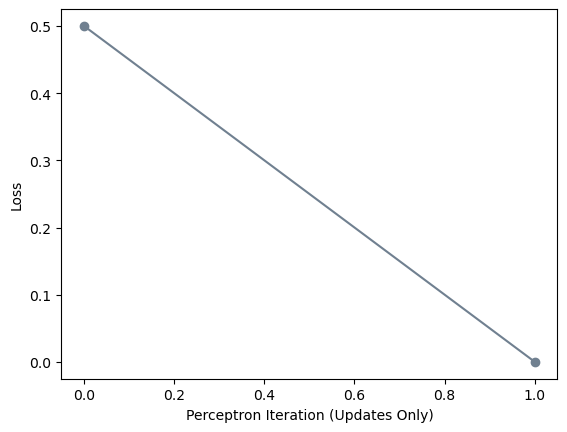

In [95]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []
train_minibatch(X,y, k = 10, lr = 1)
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))
print("Weight Vector: " + str(p.w))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

#### Experiment 3: K = n

In this experiment, we try to see whether our minibatch perceptron algorithm can converge even when the data isn't linearly separable, assuming the learning rate is small enough. To this end, we create data with high noise and set lr = 0.01 in training.

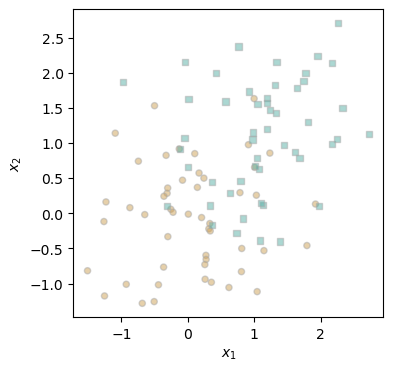

In [96]:
kn=100
torch.manual_seed(1250)
X, y = perceptron_data(kn,0.8)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

The above plot shows our data is not linearly separable.

Last Loss: tensor(0.2800)
Weight Vector: tensor([15.4484, 17.5780,  0.6154])


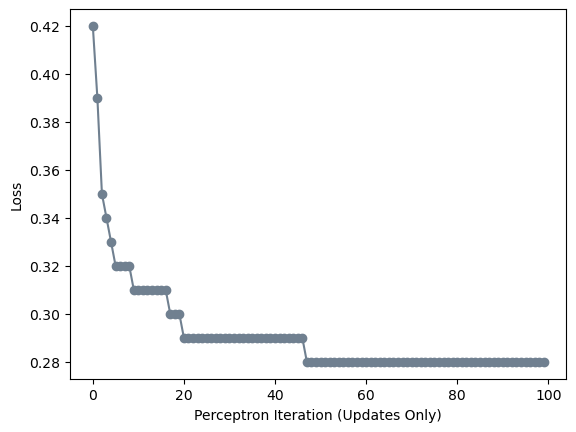

In [97]:
p = Perceptron() 
opt = PerceptronOptimizer(p)
loss_vec = []

train_minibatch(X,y,max_iterations=100,loss_threshold=0.01,k=kn, lr=0.01)
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))
print("Weight Vector: " + str(p.w))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "Loss")

The above graph shows that, when k=n, we do see a fast and dramatic drop in the loss, but the loss then levels off at 0.28, which is to be expected since the data isn't linearly separable.

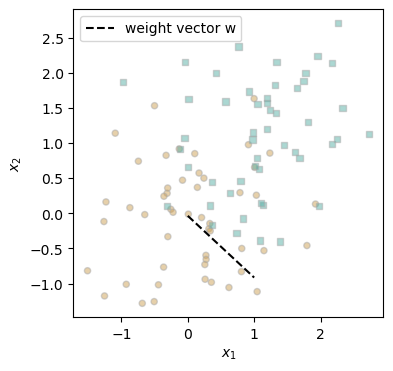

In [98]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")
l = ax.legend(ncol = 2)

The above visualizes our weight vector against our data. It seems to do a decent job of correctly categorizing green points, but it has many false negatives for yellow points.

### Part D: Writing

k = number of minibatched observations
p = number of features 
* **What is the runtime complexity of a single iteration of the perceptron algorithm?**

        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random data point
        i = torch.randint(n, size = (1,))
        x_i = X[[i],:]
        y_i = y[i]
        
        # perform a perceptron update using the random data point
        opt.step(x_i, y_i)

* First, it calls loss(). In loss(), the first line of arithmetic is $O(1)$. The second line calls score(), transforms the result, and calculates its mean. Score() applies matrix multiplication on x, a $1 \times \mathbf{p}$ matrix, and our weight vector, which is $\mathbf{p} \times 1$. So our runtime is $O(1*p*1) = O(p)$. We apply a transformation, multiplying the score by an integer and then determining the result of an inequality. That takes $O(1)$ time. We then calculate the mean. That also takes $O(1)$ time, since there's only one data point. So all of loss() is $O(p)$ time.
* Then we pick a random data point. I'm not sure what the runtime of randint is--I ambitiously assume it's $O(1)$. Then we call step(), which calls loss() and grad(). loss() is $O(p)$ as mentioned. grad() calls score(), which is $O(p)$. We create a vector siyi that is the result of multiplying scores by y, which is an $O(p)$ operation. Then we perform matrix multiplication on siyi, a $1 \times 1$ matrix, and X, which is $1 \times \mathbf{p}$. This multiplication is O(p).
* A single iteration is $O(p)$.
* **Does the runtime complexity of a single iteration depend on the number of data points? What about the number of features?**
* Runtime complexity is only dependent on the number of features, not the number of data points.
* **If you implemented minibatch perceptron, what is the runtime complexity of a single iteration of the minibatch perceptron algorithm?**
* First, it calls loss(). Score(), transforms the result, and calculates its mean. Score() applies matrix multiplication on x, a $k \times \mathbf{p}$ matrix, and our weight vector, which is $\mathbf{p} \times 1$. So our runtime is $O(k*p*1) = O(kp)$. We apply a transformation, multiplying each score by an integer and then determining the result of an inequality. That takes $O(k)$ time. We then calculate the mean. That also takes $O(k)$ time. So all of loss() is $O(kp)$ time.
* Then we pick a random data point. I'm not sure what the runtime of randint is--I ambitiously assume it's $O(k)$. Then we call step(), which calls loss() and grad(). loss() is $O(kp)$ as mentioned. grad() calls score(), which is $O(kp)$. We create a vector siyi that is the result of multiplying each score with each y value, which is an $O(k)$ operation. We transform siyi from a $k \times 1$ into a $1 \times k$ matrix, which I ambitiously assume is a $O(1)$ operation. Then we perform matrix multiplication on transformed siyi, a $1 \times k$ matrix, and X, which is $k \times \mathbf{p}$. This multiplication is $O(1*k*p)$.
* A single iteration with the minibatch perceptron algorithm is $O(kp)$


#### Description of grad() Function Implementation

    def grad(self, X, y, ix = None):
        if (ix == None): #Normal perceptron
            scores = LinearModel.score(self, X) 
            siyi = torch.where(scores*y<0,1.0,0.0)
            return y.float()*(siyi@X)

        else: #Minibatch perceptron
            scores = LinearModel.score(self, X[ix,:])
            siyi = torch.where(scores*y[ix]<0,1.0,0.0)
            return torch.sum(siyi.reshape(-1,1)*(y[ix].float()@X[ix,:]),0) / len(y[ix])


In implementing grad() and step(), I included an if-else for whether an argument is passed for ix. If it isn't, the functions run the normal perceptron algorithm. If an argument is passed, the function runs the minibatch perceptron algorithm.

Either way, my grad() function consists of three steps:
1. Compute scores (matrix multiplication of X and our weights)
2. Create a new array / vector (siyi) solely consisting of 1s and 0s. Each item is 1 only if it's incorrectly classified: i.e., if an observation's predicted and actual values are incongruent
3. (Normal perceptron) We perform matrix multiplication of siyi and X, which is multiplied by the floating point value y. Or (multibatch) we transform siyi into a column vector and matrix multiply it by our randomly selected y values with our randomly selected X rows. Then we divide by the number of randomly selected observations (k).

#### Conclusion

This was the most difficult and frustrating homework I've worked on. I spent two hours debugging a single issue with the grad() equation: instead of transpose(siyi<0)\*y[ix]@X[ix,:], I wrote transpose y[ix]\*(siyi<0)@X[ix,:], which made rows of my matrix just cancel out because there are an equal number of correct and incorrect answers. However, although my learning there wasn't very efficient, I feel like I still learned a great deal from this assignment and even debugging that specific issue. In particular, it forced me to engage more with basic linear algebra and go back to the basics on understanding matrix multiplication. I've also never worked with torch tensors before, so this post helped me gain some familiarity with them.